# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

We will familiarize ourselves with the data by performing EDA to identify trends, spot anaomiles, select features, and more. Once this stage is complete, we will build a regression model to predict house prices. 


In [24]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sqlalchemy import create_engine
import warnings


# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning 

First, we will clean column names by stripping spaces and convert to lower case. Then, we will detect null values and fill in with interpolation since the data is a time series.  

In [5]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


There are 81 attributes and 1,460 rows in this dataset. Currently, majority of the attributes are categorical variables describing features of our the target variable, sale price. There are also many continous variables, such as lot area and sizing of the house. 

Let's get a basic description of the dataset by viewing summary statistics.

In [6]:
# Datafram statistics 

df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Here are some initial observations:
 - Lot area varies drastically from 1,300 square feet (2 bedroom) to 215,245  square feet (mega-mansion).
 - These houses were built from 1872 to 2010. The average house in this dataset was built around 1971.
 - The average pool area is around 2 square feet which indicates that these houses probably do not have a pool. This may be typical of a house in Iowa. 
 - These houses were sold during 2006 to 2010. 
 - The sale prices ranges from \$34,900 to \$755,000. The average price for a house was around \$180,921. 


We will continue exploring the data by taking a closer look into the data types.

In [7]:
# Datatypes 

df.dtypes

num_var = df.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = df.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 38 numeric varibles
There are 43 categorical varibles


This dataset consists of 35 numeric variables and 27 categorical variables. 

Let's investigate the null values. 

In [8]:
# Percentage of missing values

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


We can observe that the top 6 variables in the table are missing more than 15% of datapoints. Since these features don't appear to be the top qualities of what people may prioritize when purchasing a house, we will delete these columns. 

The remaining variables share common characteristics and the number of missing values with other columns. For example, there are 5 columns describing the garage feature of a house. All of the garage variables are missing 81 values, which may have occurred from logging a particular observation. Home buyers would more likely be interested in the number of cars a garage can store, we will delete these extra garage variables. This logic will be applied to the remaining variables as well. 


In [9]:
# Drop missing data

df = df.drop((missing_data[missing_data['Total'] >= 1]).index,1)

# Check for missing data
df.isnull().sum().max() 

0

There doesn't appear to be obvious missing values so we will find the correlation between numeric features and sale price.  

In [10]:
# Correlation between sale price and numeric variables 

corrmat = df.corr()
print(corrmat['saleprice'].sort_values(ascending = False),'\n')

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64 



The most correlated variables to sale price:
 - overallqual: overall material and finish quality
 - grlivarea: above grade (ground) living area square feet
 - garagecars: size of garage in car capacity
 - garagearea: size of garage in square feet
 - totalbsmtsf: total square feet of basement area
 - firstflrsf: first floor square feet

These results make sense since buyers would be interested in knowing the general living space, quality of the house, and garage capacity.  

With the variables identified above, we will continue to explore their relationship with sale price through scatter plots. 

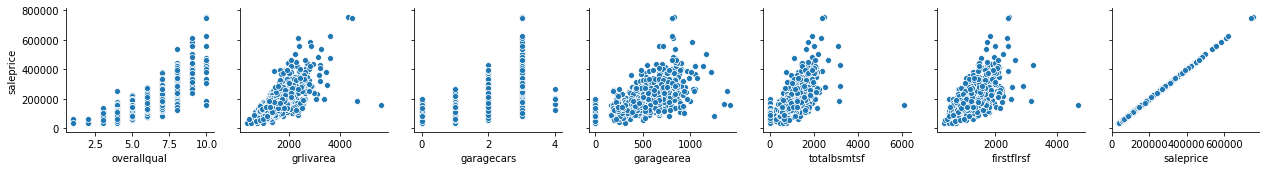

In [11]:
top_var = df.loc[:,['overallqual','grlivarea','garagecars',
                    'garagearea','totalbsmtsf','firstflrsf','saleprice']]
sns.pairplot(top_var, y_vars="saleprice", x_vars=top_var.columns.values)

We can observe that most of the variables have somewhat of a linear relationship with sale price. The scatter plot also offers insight in possible outliers. We can see outliers on the far right for ground living area, garage area, total basement area, first floor, and sale price. 

Since some machine learning models are sensitive to extreme values, we will identify outliers by using standard deviation and replace them with the median value. 

In [15]:
# Create function to detect outliers by using standard deviation 

def out_std(s):
    # calculate summary statistics
    data_mean, data_std = s.mean(), s.std()
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in s if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    print(outliers)
    outliers_removed = [x for x in s if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))


In [16]:
# Outlier values 

out_std(df['overallqual'])
out_std(df['grlivarea'])
out_std(df['garagecars'])
out_std(df['garagearea'])
out_std(df['totalbsmtsf'])
out_std(df['firstflrsf'])

Identified outliers: 0
[]
Non-outlier observations: 1460
Identified outliers: 5
[2945.0, 2978.0, 2898.0, 3082.0, 3086.0]
Non-outlier observations: 1455
Identified outliers: 0
[]
Non-outlier observations: 1460
Identified outliers: 0
[]
Non-outlier observations: 1460
Identified outliers: 1
[2330.0]
Non-outlier observations: 1459
Identified outliers: 5
[2223.0, 2259.0, 2234.0, 2217.0, 2364.0]
Non-outlier observations: 1455


NOTE: I have not figured out a way to automatically remove outliers and save it in a new dataset. 

In [17]:
# Replacing outliers with median values 

median = df['overallqual'].median()
df["overallqual"] = np.where(df["overallqual"] == 1, median,df['overallqual'])    

median = df['grlivarea'].median()
df["grlivarea"] = np.where(df["grlivarea"] >= 3112, median,df['grlivarea'])

median = df['garagearea'].median()
df["garagearea"] = np.where(df["garagearea"] >= 1134, median,df['garagearea'])  

median = df['totalbsmtsf'].median()
df["totalbsmtsf"] = np.where(df["totalbsmtsf"] >= 2392, median,df['totalbsmtsf'])  

median = df['firstflrsf'].median()
df["firstflrsf"] = np.where(df["firstflrsf"] >= 2392, median,df['firstflrsf'])  

## Exploring Data 
First, let's look at the distribution of our target variable: sale price. Investigating how our target is distributed helps us understand the relationship between the target and the features. 

Text(0.5, 1.0, 'Sale Price')

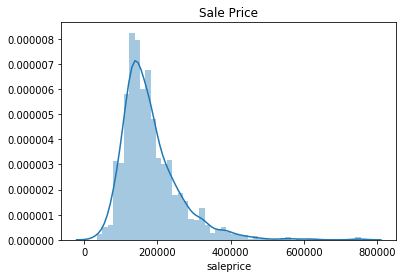

In [18]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. This may be due to some prices being listed at $750,000 and above. 

Since the target variable does not need to be normally distributed for a linear regression model, we will continue. 

## Feature Engineering
In this step, we will select features for our linear regression model. First, let's start with the numeric values. Previously, we identified 6 numeric variables that are highly correlated to sale price. We will use a heat map to check if the variables on highly correlated to each other before continuing. 

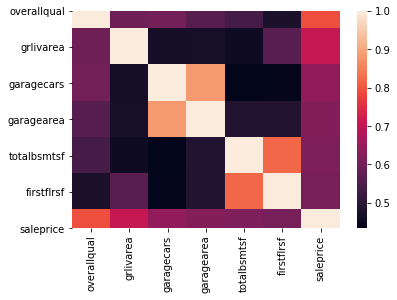

In [19]:
# Heatmap of most correlated variables 

corrmat = top_var.corr()
sns.heatmap(corrmat)

The variables look relatively independent of each other. Let's try running our first linear regression model with only numeric variables. 

### Iteration 1

In [25]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes
X = df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.72858192e+04 3.72755380e+01 6.29575370e+01 2.73822472e+01
 1.90324710e+01]

Intercept: 
 -121239.52661336868


LinearRegression fit method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ saleprice = -121239.52 + 27,285.82\_overallqual + 37.28\_grlivarea + 62.96\_garagearea + 27.38\_totalbsmtsf + 19.03\_firstflrsf

In [26]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     851.8
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:18:53   Log-Likelihood:                -17545.
No. Observations:                1460   AIC:                         3.510e+04
Df Residuals:                    1454   BIC:                         3.513e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.212e+05   5191.534    -23.353      0.000   -1.31e+05   -1.11e+05
overallqual  2.729e+04   1072.410     25.443      0.000    2.52e+04    2.94e+04
grlivarea      37.2755      2.926     12.740      0.000      31.536      43.015
garagearea     62.9575      6.480      9.716      0.000      50.247      75.668
totalbsmtsf    27.3822      4.632      5.911      0.000      18.296      36.469
firstflrsf     19.0325      5.210      3.653      0.000       8.813      29.252
==============================================================================
Omnibus:                     1061.246   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42733.591
Skew:                           2.910   Prob(JB):                         0.00
Kurtosis:                      28.857   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

NOTE: I am not sure of how I am suppose to interpet the results. 

## Iteration 2 

The variables look relatively independent of each other. Let's continue to explore the categorical variables. We will need to convert strings to numerical values. We will use __one hot encoding__ to separate variables into numbers for each unique value. 

In [21]:
# Create dataframe of categorical variables 

cat_var_dum = pd.get_dummies(cols = cat_var.columns, drop_first=True)
cat_var_dum.head()

AttributeError: 'Index' object has no attribute 'columns'